# Lab. 12: Robust Optimization

## Introduction

#### <u>In this lab, we will see some applications of robust optimization, namely a modified version of the Knapsack 0/1 problem, and the portfolio optimization problem.</u>

Your job in this lab is to implement the missing functions, and study how different functions lead to different outcomes from both the point of view of the objective value and the probability of violating the constraints of the problem.

The examples are taken from https://xiongpengnus.github.io/rsome/ro_rsome, using the RSOME library for robust optimization.

In [61]:
# @title Imports

!pip install -q rsome
!pip install -q gurobipy

from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from math import floor
import pprint

## Exercises

### Exercise 1/2: Modified Knapsack 0/1 Problem

In this exercise, we will solve the Knapsack problem (seen in the previous labs), slightly modified in order to have uncertainties about the volumes of the items.

The uncertainty about the volumes is not the same for all the items. They are defined by  δ , defined as a fraction of the size of the volumes of the items.

In this exercise, you are asked to implement the definition of the uncertainty set in order to have both an ellipsoidal uncertainty set and a finite uncertainty set.

#### Task
Implement different sizes for the ellipsoid and different interval for the finite set and compare the objective values and the probability of violating the constraints with the different setups.

In [62]:
# @title Helper Functions

items = [
    {'name': 'apple', 'value': 1, 'volume': 2},
    {'name': 'pear', 'value': 2, 'volume': 2},
    {'name': 'banana', 'value': 2, 'volume': 2},
    {'name': 'watermelon', 'value': 5, 'volume': 10},
    {'name': 'orange', 'value': 3, 'volume': 2},
    {'name': 'avocado', 'value': 3, 'volume': 2},
    {'name': 'blueberry', 'value': 3, 'volume': 1},
    {'name': 'coconut', 'value': 4, 'volume': 3},
    {'name': 'cherry', 'value': 2, 'volume': 1},
    {'name': 'apricot', 'value': 1, 'volume': 1},
    {'name': 'cioccolato', 'value': 10, 'volume': 5},
    {'name': 'caramelle', 'value': 8, 'volume': 3},
    {'name': 'torta di mele', 'value': 3, 'volume': 2},
    {'name': 'salame al cioccolato', 'value': 5, 'volume': 4},
    {'name': 'zuppa', 'value': 1, 'volume': 6},
    {'name': 'muesli al cioccolato', 'value': 9, 'volume': 5},
    {'name': 'succhino alla pera', 'value': 3, 'volume': 2}
]

N = len(items)
b = 10

c = np.array([i['value'] for i in items]).flatten()  # profit coefficients
w = np.array([i['volume'] for i in items]).flatten()  # weight coefficients

delta = 0.2*w  # maximum deviations

def robust(get_uncertainty_set, r):
    """
    The function robust implements the robust optimiztion model,
    given the budget of uncertainty r
    """

    model = ro.Model('robust')
    x = model.dvar(N, vtype='B')  # Boolean variable x (0: leave, 1: keep)
    z = model.rvar(N)             # Random variable

    # Uncertainty set
    z_set = get_uncertainty_set(z, r)
    model.max(c @ x)              # Maximize the value of the knapsack (i.e., the dot product between the values and x)

    # Add constraint: the maximum (uncertain) volume is smaller than the budget
    # in ellipsoidal uncertainty set, 'M' is 'delta' and 'u' is 'z'
    # in finite uncertainty set, p1 = w + z1*delta => z1 = (p1 - w)/delta
    model.st(((w + z*delta) @ x <= b).forall(z_set))
    #consider the optimization with constraint "Ax <= b", here A = w + z*delta

    # Solve
    model.solve(grb, display=False)

    return model.get(), x.get()    # Return the optimal objective and solution


def sim(x_sol, zs):
    """
    The function sim is for calculating the probability of violation
    via simulations.
        x_sol: solution of the Knapsack problem
        zs: random sample of the random variable z
    """

    ws = w + zs*delta   # random samples of uncertain weights

    return (ws @ x_sol > b).mean()

"""
Define an uncertainty set. See the following sources:
- Ellipsoidal: https://xiongpengnus.github.io/rsome/ro_rsome#section2.2
- Finite Uncertainty Set
"""

def ellipsoidal_uncertainty_set(z, r):

    z_set = (rso.norm(z, 2) <= r)
    return z_set

def finite_uncertainty_set(z, r):
    z_set = (
        (z <= r[0], z >= r[0]) or
        (z <= r[1], z >= r[1]) or
        (z <= r[2], z >= r[2])
    )
    return z_set

def finite_uncertainty_set_big(z, r):
    z_set = (
        (z <= r[0], z >= r[0]) or
        (z <= r[1], z >= r[1]) or
        (z <= r[2], z >= r[2]) or
        (z <= r[3], z >= r[3]) or
        (z <= r[4], z >= r[4]) or
        (z <= r[5], z >= r[5])
    )
    return z_set

def finite_uncertainty_set_hardcoded(z, r):
    z_set = (
        (z <= 0, z >= 0) or
        (z <= 1, z >= 1) or
        (z <= 2, z >= 2) or
        (z <= 3, z >= 3) or
        (z <= 4, z >= 4) or
        (z <= 5, z >= 5)
    )
    return z_set

## ellipsoide
The model considers the worst-case scenario within the ellipsoid. For example, the constraint 
(w+z⋅δ)⋅x≤b ensures that the solution x remains feasible for any z within the ellipsoid.

With a small radius you get higher values but have a much higher probability of violating the constraint because you give less weight to uncertainty

In [63]:
num_samples = 20000
zs = np.random.uniform(-1, 1, (num_samples, N))  # Generate random samples for z

for r in [0, 1, 3, 5, 10]:
    print('raggio: ',r)
    objective_value, solution = robust(ellipsoidal_uncertainty_set, r)
    prob_violation = sim(solution, zs)

    print(f'Content of the knapsack:')
    for i, value in enumerate(solution):
        if value:
            print(f'\t{items[i]["name"]}')
    print(f'Total value: {objective_value}. Probability of violation: {prob_violation}')
    print('\n\n')

raggio:  0
Content of the knapsack:
	blueberry
	cherry
	cioccolato
	caramelle
Total value: 23.0. Probability of violation: 0.49815



raggio:  1
Content of the knapsack:
	blueberry
	cherry
	caramelle
	torta di mele
	succhino alla pera
Total value: 19.0. Probability of violation: 0.0225



raggio:  3
Content of the knapsack:
	blueberry
	cherry
	caramelle
	succhino alla pera
Total value: 16.0. Probability of violation: 0.0



raggio:  5
Content of the knapsack:
	blueberry
	caramelle
	torta di mele
Total value: 14.0. Probability of violation: 0.0



raggio:  10
Content of the knapsack:
	orange
	blueberry
	cherry
Total value: 8.0. Probability of violation: 0.0





## finite set

The model includes constraints for each scenario in the finite set. For example, if the uncertainty set consists of scenarios, the constraint becomes (w+zi​⋅δ)⋅x≤b for each zi

In [69]:
import numpy as np

num_samples = 20000
zs = np.random.uniform(-1, 1, (num_samples, N))  # Generate random samples for z


for r in [[0.001, 1, 10], [5, 7, 9], [0.1, 0.3, 0.5], [0.0001, 0.1, 0.01]]:
    valori = []
    probViolation = []
    print('r: ',r)
    for k in range(100):
        zs = np.random.uniform(-1, 1, (num_samples, N))  # Generate random samples for z
        objective_value, solution = robust(finite_uncertainty_set, r)
        prob_violation = sim(solution, zs)
        if k == 3:
            print(f'Content of the knapsack:')
            for i, value in enumerate(solution):
                if value:
                    print(f'\t{items[i]["name"]}')
            print(f'Total value: {objective_value}. Probability of violation: {prob_violation}')
        valori.append(objective_value)
        probViolation.append(prob_violation)
    
    print(f'Total value medio: {np.mean(valori)}. Probability of violation medio: {np.mean(probViolation)} +- {np.var(probViolation)}\n\n')

    

r:  [0.001, 1, 10]
Content of the knapsack:
	blueberry
	cioccolato
	caramelle
Total value: 21.0. Probability of violation: 0.0786
Total value medio: 21.0. Probability of violation medio: 0.07784300000000001 +- 3.9108509999999985e-06


r:  [5, 7, 9]
Content of the knapsack:
	blueberry
	cherry
	caramelle
Total value: 13.0. Probability of violation: 0.0
Total value medio: 13.0. Probability of violation medio: 0.0 +- 0.0


r:  [0.1, 0.3, 0.5]
Content of the knapsack:
	blueberry
	cioccolato
	caramelle
Total value: 21.0. Probability of violation: 0.07775
Total value medio: 21.0. Probability of violation medio: 0.07757499999999999 +- 4.258825e-06


r:  [0.0001, 0.1, 0.01]
Content of the knapsack:
	blueberry
	cioccolato
	caramelle
Total value: 21.0. Probability of violation: 0.0784
Total value medio: 21.0. Probability of violation medio: 0.07763300000000001 +- 3.480510999999999e-06




In [73]:
for r in [[10, 0.0001, 0.001, 1,  5], [5, 0.1, 0.3, 0.5, 7, 9], [0.00000001, 0.0001, 0.1, 0.01, 0.001, 1]]:#, [5, 7, 9], [0.1, 0.3, 0.5], [0.0001, 0.1, 0.01]
    valori = []
    probViolation = []
    print('r: ',r)
    for k in range(100):
        zs = np.random.uniform(-1, 1, (num_samples, N))  # Generate random samples for z
        objective_value, solution = robust(finite_uncertainty_set_big, r)
        prob_violation = sim(solution, zs)
        if k == 3:
            print(f'Content of the knapsack:')
            for i, value in enumerate(solution):
                if value:
                    print(f'\t{items[i]["name"]}')
            print(f'Total value: {objective_value}. Probability of violation: {prob_violation}')
        valori.append(objective_value)
        probViolation.append(prob_violation)
    
    print(f'Total value medio: {np.mean(valori)}. Probability of violation medio: {np.mean(probViolation)} +- {np.var(probViolation)}\n\n')

    

r:  [10, 0.0001, 0.001, 1, 5]
Content of the knapsack:
	caramelle
Total value: 8.0. Probability of violation: 0.0
Total value medio: 8.0. Probability of violation medio: 0.0 +- 0.0


r:  [5, 0.1, 0.3, 0.5, 7, 9]
Content of the knapsack:
	blueberry
	cherry
	caramelle
Total value: 13.0. Probability of violation: 0.0
Total value medio: 13.0. Probability of violation medio: 0.0 +- 0.0


r:  [1e-08, 0.0001, 0.1, 0.01, 0.001, 1]
Content of the knapsack:
	blueberry
	cherry
	cioccolato
	caramelle
Total value: 22.999999959999997. Probability of violation: 0.49905
Total value medio: 22.999999959999997. Probability of violation medio: 0.500046 +- 1.2119384000000011e-05




### Exercise 2/2: Robust Portfolio Optimization

In this problem, we want to build a portfolio (e.g., of stocks), by using robust approaches.

To be more specific, in this problem we have a set of fictionary stocks, each of which has different means and deviations for the returns.

#### TASK
Your job here is to implement a box uncertainty set to robustly optimize the portfolio. Try different values for the box in order to study how the uncertainty affects the objective value of and the number of different stocks chosen.

In [66]:
# @title Helper Functions

n = 10
stocks = {
    f'Company {chr(65+i)}': {'Mean': np.around(np.random.uniform(0.9, 1.1), 2), 'Deviation': np.around(np.random.uniform(0.1, 0.3), 2)}
    for i in range(n)
}

stocks = {
    'Company A': {'Deviation': 0.17, 'Mean': 0.97},
    'Company B': {'Deviation': 0.22, 'Mean': 0.92},
    'Company C': {'Deviation': 0.28, 'Mean': 0.95},
    'Company D': {'Deviation': 0.22, 'Mean': 1.04},
    'Company E': {'Deviation': 0.23, 'Mean': 0.97},
    'Company F': {'Deviation': 0.24, 'Mean': 1.08},
    'Company G': {'Deviation': 0.27, 'Mean': 1.05},
    'Company H': {'Deviation': 0.12, 'Mean': 1.01},
    'Company I': {'Deviation': 0.24, 'Mean': 1.03},
    'Company J': {'Deviation': 0.29, 'Mean': 0.95}
}

def portfolio_optimization(get_uncertainty_set, l, u):
    p = np.array([stocks[s]['Mean'] for s in stocks])  # mean returns
    delta = np.array([stocks[s]['Deviation'] for s in stocks])  # deviations of returns
    Gamma = 5                               # budget of uncertainty

    model = ro.Model()
    x = model.dvar(n)                       # fractions of investment
    z = model.rvar(n)                       # random variables

    z_set = get_uncertainty_set(z, l, u)

    model.maxmin(
        (p + delta*z) @ x,                  # the max-min objective
        z_set
    )

    model.st(sum(x) == 1)                   # summation of x is one
    model.st(x >= 0)                        # x is non-negative

    model.solve(grb)                        # solve the model by Gurobi
    return model.get(), x.get()


def get_uncertainty_set_po(z, l, u):
    """
    Return a box uncertainty set
    (see https://xiongpengnus.github.io/rsome/example_ro_inv).

    Try different values for the size of the box.
    """
    z_set = (
        z <= u,
        z >= l
    )
    return z_set

def get_uncertainty_set_po_norm(z, l, u):
    """
    Return a box uncertainty set
    (see https://xiongpengnus.github.io/rsome/example_ro_inv).

    Try different values for the size of the box.
    """
    z_set = (
        rso.norm(z, 1) <= u
    )
    return z_set

box:  [10, 20]
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s


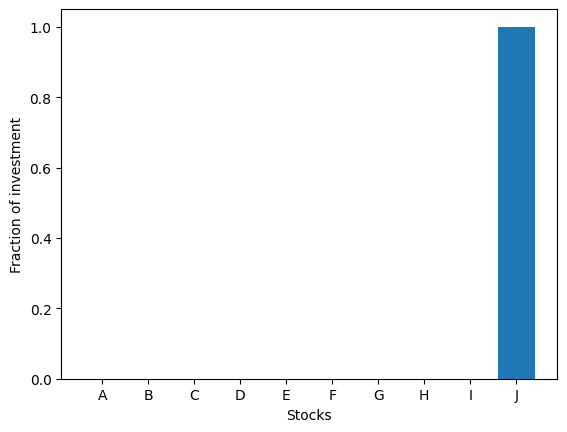

Objective value: 3.8500
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0010s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0010s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Total value medio: 3.85 +- 1.9721522630525295e-31


box:  [1, 2]
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s


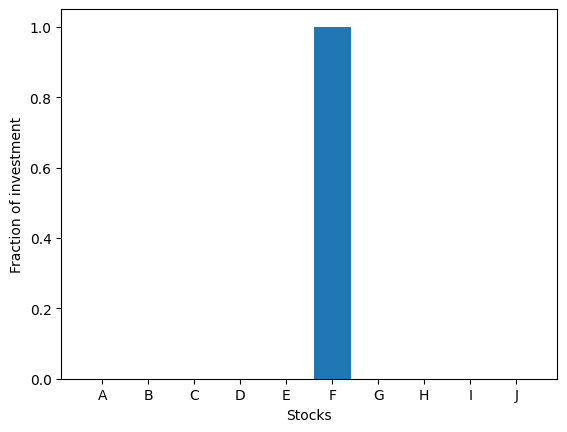

Objective value: 1.3200
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0020s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0010s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0010s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Total value medio: 1.32 +- 0.0


box:  [1e-05, 0.0001]
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s


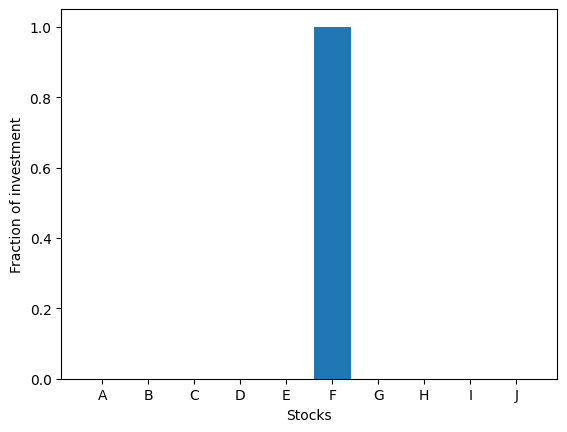

Objective value: 1.0800
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Total value medio: 1.0800024000000001 +- 0.0




In [78]:

for box in [[10, 20], [1,2], [0.00001,0.0001]]:
    valori = []
    print('box: ',box)

    for k in range(10):
        obj_val, x_sol = portfolio_optimization(get_uncertainty_set_po, box[0], box[1])
        
        if k == 1:
            plt.bar(
                [s.split(' ')[1] for s in stocks],  # Stock names
                x_sol,                              # Fraction of the portfolio
            )
            plt.xlabel('Stocks')
            plt.ylabel('Fraction of investment')
            plt.show()
            print('Objective value: {0:0.4f}'.format(obj_val))

        valori.append(obj_val)
    
    print(f'Total value medio: {np.mean(valori)} +- {np.var(valori)}\n\n')

    

box:  [10, 20]
Being solved by Gurobi...


Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s


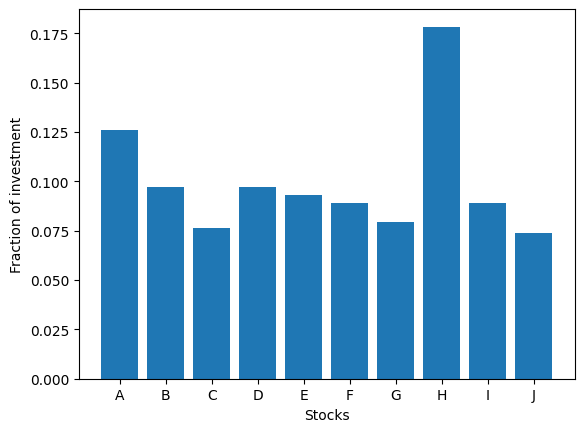

Objective value: 0.5694
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0010s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Total value medio: 0.5694207623201641 +- 0.0


box:  [1, 2]
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s


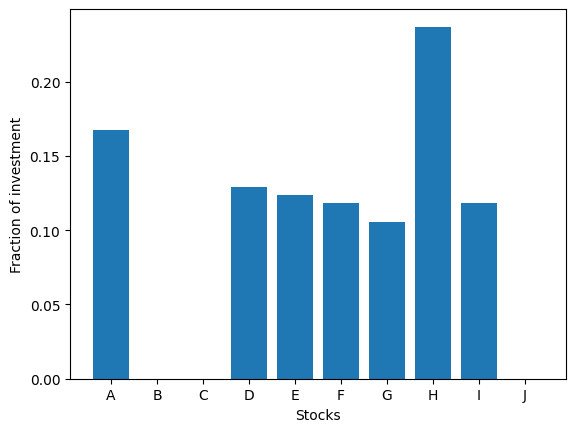

Objective value: 0.9602
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0020s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Total value medio: 0.9602163779585435 +- 0.0


box:  [1e-05, 0.0001]
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s


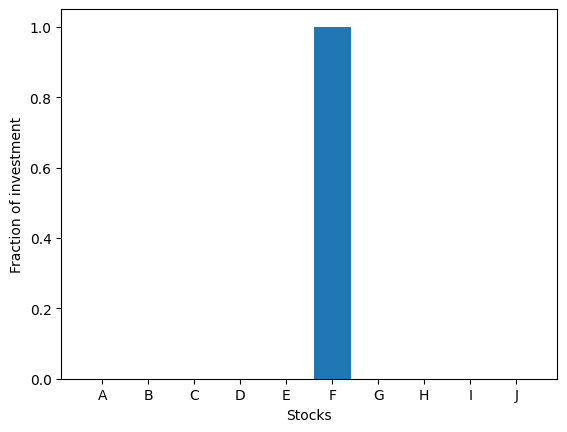

Objective value: 1.0800
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0010s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0000s
Total value medio: 1.079976 +- 0.0




In [79]:

for box in [[10, 20], [1,2], [0.00001,0.0001]]:
    valori = []
    print('box: ',box)

    for k in range(10):
        obj_val, x_sol = portfolio_optimization(get_uncertainty_set_po_norm, box[0], box[1])
        
        if k == 1:
            plt.bar(
                [s.split(' ')[1] for s in stocks],  # Stock names
                x_sol,                              # Fraction of the portfolio
            )
            plt.xlabel('Stocks')
            plt.ylabel('Fraction of investment')
            plt.show()
            print('Objective value: {0:0.4f}'.format(obj_val))

        valori.append(obj_val)
    
    print(f'Total value medio: {np.mean(valori)} +- {np.var(valori)}\n\n')